In [1]:
import os
import json
from PIL import Image
from pycocotools.coco import COCO
import torch
from torchvision import transforms

class CustomCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        # Load the image
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        # Prepare target
        num_objs = len(coco_annotation)
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            areas.append(coco_annotation[i]['area'])
            iscrowd.append(coco_annotation[i]['iscrowd'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids)


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Instantiate your dataset
dataset = CustomCOCODataset(root='data/license_plates/train/images', 
                            annotation='data/license_plates/train/_annotations.coco.json',
                            transform=transform)

# Test
print(len(dataset))
dataset[0]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
245


(tensor([[[0.6314, 0.5765, 0.1922,  ..., 0.4275, 0.3882, 0.3333],
          [0.4196, 0.5255, 0.1490,  ..., 0.6745, 0.6510, 0.6706],
          [0.4824, 0.5725, 0.4118,  ..., 0.4196, 0.3294, 0.2588],
          ...,
          [0.9333, 0.9373, 0.8706,  ..., 0.2980, 0.3882, 0.5137],
          [1.0000, 0.9725, 0.9255,  ..., 0.2902, 0.3647, 0.4510],
          [0.9647, 0.9059, 0.8902,  ..., 0.2863, 0.3333, 0.3529]],
 
         [[0.7059, 0.6510, 0.2667,  ..., 0.4980, 0.4588, 0.4039],
          [0.4941, 0.6000, 0.2235,  ..., 0.7333, 0.7098, 0.7294],
          [0.5686, 0.6588, 0.4980,  ..., 0.4784, 0.3882, 0.3176],
          ...,
          [0.9216, 0.9294, 0.8745,  ..., 0.3647, 0.4627, 0.5843],
          [0.9882, 0.9647, 0.9255,  ..., 0.3647, 0.4353, 0.5216],
          [0.9490, 0.8941, 0.8941,  ..., 0.3608, 0.4039, 0.4353]],
 
         [[0.6314, 0.5765, 0.1922,  ..., 0.4039, 0.3725, 0.3176],
          [0.4157, 0.5216, 0.1451,  ..., 0.6510, 0.6275, 0.6471],
          [0.4784, 0.5686, 0.4078,  ...,

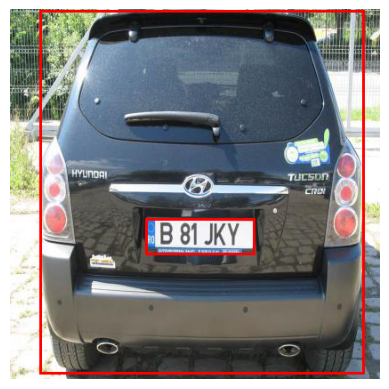

In [3]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import torchvision.utils as utils
import matplotlib.pyplot as plt

img, target = dataset[0]

# Convert the image to a tensor if it's not already
if not isinstance(img, torch.Tensor):
    img = F.to_tensor(img)

# Convert back to uint8 for drawing boxes
if img.dtype == torch.float32:
    img = (img * 255).type(torch.uint8)
    
# Draw the bounding boxes on the image
img_with_boxes = utils.draw_bounding_boxes(img, target['boxes'], width=3, colors='red')

# Convert the tensor to PIL Image for display
img_with_boxes = F.to_pil_image(img_with_boxes)

# Display the image
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    #now get the number of input features for the mask classifier
    #in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    #hidden_layer = 256
    # and replace the mask predictor with a new one
    #model.roi_heads.mask_predictor = MaskRCNNPredictor(
    #    in_features_mask,
    #    hidden_layer,
    #    num_classes
    #)

    return model

In [5]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# use our dataset and defined transformations
dataset = CustomCOCODataset(root='data/license_plates/train/images', 
                            annotation='data/license_plates/train/_annotations.coco.json',
                            transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    #shuffle=True,
    #num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [  0/245]  eta: 0:09:49  lr: 0.000025  loss: 1.3457 (1.3457)  loss_classifier: 1.1137 (1.1137)  loss_box_reg: 0.2002 (0.2002)  loss_objectness: 0.0160 (0.0160)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 2.4043  data: 0.0016  max mem: 951
Epoch: [0]  [ 10/245]  eta: 0:09:25  lr: 0.000230  loss: 1.3842 (1.7348)  loss_classifier: 1.0544 (0.9154)  loss_box_reg: 0.2002 (0.3022)  loss_objectness: 0.1367 (0.4242)  loss_rpn_box_reg: 0.0181 (0.0930)  time: 2.4050  data: 0.0422  max mem: 1104
Epoch: [0]  [ 20/245]  eta: 0:07:53  lr: 0.000435  loss: 0.9506 (1.2612)  loss_classifier: 0.4915 (0.6543)  loss_box_reg: 0.2397 (0.3125)  loss_objectness: 0.0557 (0.2376)  loss_rpn_box_reg: 0.0121 (0.0568)  time: 2.0900  data: 0.0241  max mem: 1105
Epoch: [0]  [ 30/245]  eta: 0:07:12  lr: 0.000640  loss: 0.7036 (1.1379)  loss_classifier: 0.3698 (0.5738)  loss_box_reg: 0.3098 (0.3360)  loss_objectness: 0.0312 (0.17

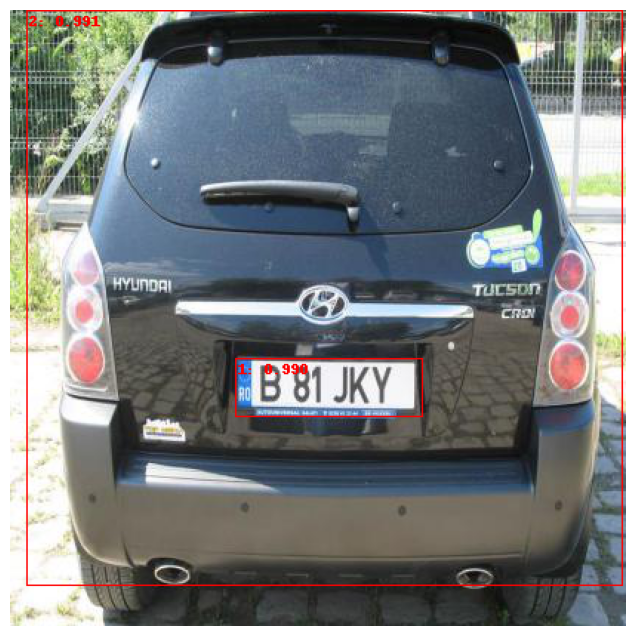

In [6]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import PILToTensor
from torchvision.io import read_image

image, targets = dataset[0]
model.eval()

with torch.no_grad():
    x = image.to(device)
    # convert RGBA -> RGB and move to device
    #x = x[0][:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Assuming 'pred' is your prediction dictionary from the model
high_confidence_threshold = 0.7
high_confidence_indices = [i for i, score in enumerate(pred["scores"]) if score >= high_confidence_threshold]

# Filter labels and boxes with scores >= 0.7
filtered_labels = [f"{pred['labels'][i]}: {pred['scores'][i]:.3f}" for i in high_confidence_indices]
filtered_boxes = pred["boxes"][high_confidence_indices].long()

# Draw bounding boxes
output_image = draw_bounding_boxes(image, filtered_boxes, labels=filtered_labels, colors="red")

# Display the image (assuming you're using matplotlib)
plt.figure(figsize=(12, 8))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')
plt.show()